In [1]:
######### this code was developped by I. Achitouv 2024 for the ABM simulations used in
######### Dynamical evolution of social network polarization and its impact on the propagation of a virus
######### please cite our article if you use this code. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings

import networkx as nx

from time import process_time
from scipy.stats import gamma
import random
from numpy import linalg as LA
import ast
import scipy.special
import random 

In [ ]:
# input parameters are: year, Tmax, 
#ptvac (probability to transmit when vaccinated), pivac (probability to infect when vaccinated),Nsimumax (nb of simulations)

******************************
frac of pro-vaccins= 0.7088324280330508 total users= 113038
******************************
mean/median nb of contact 1.9539446911658027 1.0
******************************
Assotartivity polarized network
A= 0.925045416044247
******************************
npro,nanti,Ntot 80125 32913 113038
Assotartivity unpolarized network
A= -0.000879243288399748
------------------------------------------------------------
start sim 0
start assigning Nvac= 79323 to pro vac among 113038 agents
time to run in sec 6.0
start assigning Nvac= 79211 to pro vac among 113038 agents
time to run in sec 4.0
start sim 1
start assigning Nvac= 79323 to pro vac among 113038 agents
time to run in sec 6.0
start assigning Nvac= 79211 to pro vac among 113038 agents
time to run in sec 4.0
start sim 2
start assigning Nvac= 79323 to pro vac among 113038 agents
time to run in sec 6.0
start assigning Nvac= 79211 to pro vac among 113038 agents
time to run in sec 4.0
start sim 3
start assigning Nva

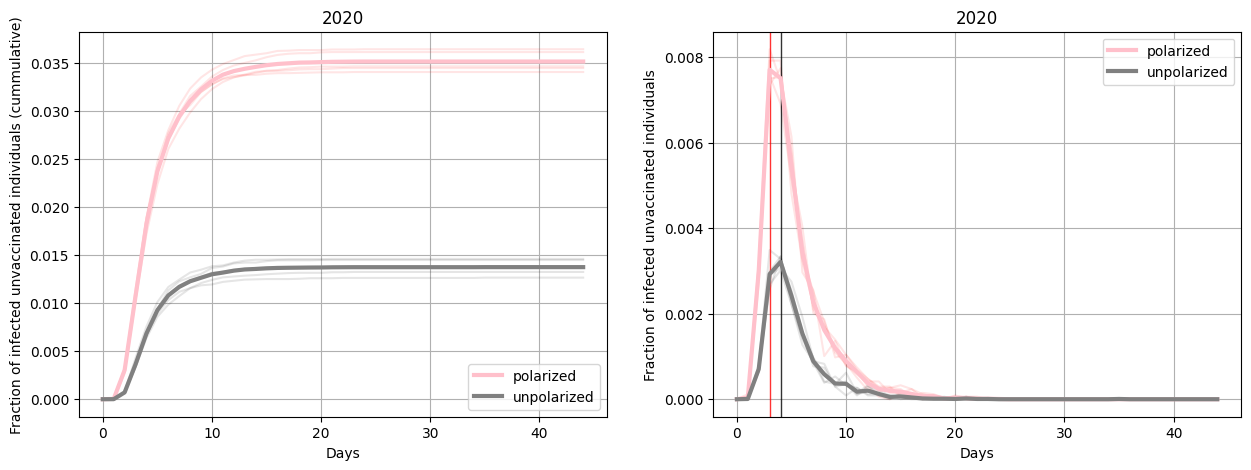

In [32]:

# select year for the network 
year=2020
Tmax=45 # nb of days max 
ptvac=0.1 
pivac=0.6 
Nsimumax=5
led='unvaccinated' # example for unvaccinated individuals


# need the Nodes and Edges files to be read in read_opinion_contact
dic_opinion,dic_cont=read_opinion_contact(year)


##########################  basic properties:
#mean nb of contacts
Ibar=computeIbar(dic_cont)

print('*'*30)
print('Assotartivity polarized network')
As=compute_As(dic_cont,dic_opinion)
#print(As)
print('*'*30)


########################## make dic_opinionran making sure the assortativity is null for the random case 
As=1.
while np.abs(As)>0.02:
    dic_opinion_ran=makedic_opinionran(dic_opinion,1)
    print('Assotartivity unpolarized network')
    As=compute_As(dic_cont,dic_opinion_ran)
   # print(As)


print('--'*30)

##### start simulation for unvaccinated 

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
Ninfall=[]
Ninfallran=[]

for i in range(Nsimumax):
    print('start sim',i)
    
    # make simulation on polarized net 
    Ninf,Nindiv,Nvac=makesimu(Tmax,dic_cont,dic_opinion,Ibar,ptvac,pivac)
    # return Ninf[day_i,population_vaccin_status] the number of infected
    # within the vaccinated population Ninf[day_i,1] and the unvaccinated population Ninf[day_i,0]   
    #total nb of indiv=,Nindiv,total nb of vaccinated individual=,Nvac)
    if led=='unvaccinated':
        Ninf=Ninf/(Nindiv-Nvac) # here we divide by total number of unvaccinated individual 
        population_vaccin_status=0
    
    
    # make simulation on unpolarized net 
    Ninf_ran,Nindiv,Nvac=makesimu(Tmax,dic_cont,dic_opinion_ran,Ibar,ptvac,pivac)
    if led=='unvaccinated':
        Ninf_ran=Ninf_ran/(Nindiv-Nvac)
        population_vaccin_status=0
    
    
    Ninfallran.append(Ninf_ran[:,population_vaccin_status]) # here 0 is for the unvaccinated indiv
    Ninfall.append(Ninf[:,population_vaccin_status])

    
    ax1.plot(np.cumsum(Ninf[:,population_vaccin_status]),color='red',alpha=0.1)
    ax1.plot(np.cumsum(Ninf_ran[:,population_vaccin_status]),color='black',alpha=0.1)
    
    ax2.plot((Ninf[:,population_vaccin_status]),color='red',alpha=0.1)
    ax2.plot((Ninf_ran[:,population_vaccin_status]),color='black',alpha=0.1)


Ninf=np.array(Ninfall)
Ninf_ran=np.array(Ninfallran)

ax1.plot(np.cumsum(np.mean(Ninf,axis=0)),label='polarized',linewidth=3,color='pink',alpha=1)
ax1.plot(np.cumsum(np.mean(Ninf_ran,axis=0)),label='unpolarized',linewidth=3,color='grey',alpha=1)

ax2.axvline(np.argmax(np.mean(Ninf,axis=0)),color='red', linestyle='-', linewidth=1,alpha=0.8)    
ax2.axvline(np.argmax(np.mean(Ninf_ran,axis=0)),color='black', linestyle='-', linewidth=1,alpha=0.8)   

ax2.plot(np.mean(Ninf,axis=0),label='polarized',linewidth=3,color='pink',alpha=1)
ax2.plot(np.mean(Ninf_ran,axis=0),label='unpolarized',linewidth=3,color='grey',alpha=1)

ax2.legend()
ax2.set_xlabel("Days")
ax2.set_ylabel("Fraction of infected "+led+" individuals")
ax2.grid(True)
ax2.set_title(str(year))
ax1.legend()
ax1.set_xlabel("Days")
ax1.set_ylabel("Fraction of infected "+led+" individuals (cummulative)")
ax1.grid(True)
ax1.set_title(str(year))



print('*'*30)
print('peak at max for polarized '+led,np.argmax(np.mean(Ninf,axis=0)))
print('peak at max for random '+led,np.argmax(np.mean(Ninf_ran,axis=0)))
print('*'*30)
m=np.cumsum(np.mean(Ninf,axis=0))
print('total infected in polarized network '+led,m[-1])
lp=[round(m[-1]*100,2),np.argmax(np.mean(Ninf,axis=0))]

m=np.cumsum(np.mean(Ninf_ran,axis=0))
print('total infected in unpolarized network '+led,m[-1])
lr=[round(m[-1]*100,2),np.argmax(np.mean(Ninf_ran,axis=0))]

# save Fig and results:
#fig.savefig('Infection_curve_'+led+str(year)+'-01-01_'+str(year)+'-12-30_th=1.0_N_agents='+str(Nindiv)+'_pt='+str(ptvac)+'_pi='+str(pivac)+'_Ibar='+str(Ibar)+'.png', dpi=100, bbox_inches='tight')
#dfepi=pd.DataFrame({'polarized': lp,
#                   'unpolarized': lr})

#dfepi.to_csv('epivar_'+str(year)+'_'+led+'.csv', index=False)  

In [30]:
def read_opinion_contact(year):
    # read opinions of users dic_opinion
    filenode='NodesId_opinion_year='+str(year)+'.csv'
    df=pd.read_csv(filenode)
    keys=df['anonyme Id'].tolist()
    values=df['pro-vac'].tolist()
    dic_opinion=dict(map(lambda i,j : (i,j) , keys,values)) #opinion dictionary
    
    print('*'*30)
    opi=list(dic_opinion.values())
    frac_pro=sum(opi)/len(opi)
    print('frac of pro-vaccins=',frac_pro,'total users=',len(opi))
    print('*'*30)
    
    
    # make the contact list per user dic_cont
    # read opinions of users 
    fileedges='EdgesSource_Target_W_year='+str(year)+'.csv'
    df=pd.read_csv(fileedges)
    df=df.loc[df['anonyme_Source'].isin(keys)]
    df=df.loc[df['anonyme_Target'].isin(keys)]
   # keys=df['anonyme_Source'].unique().tolist()
    dic_cont={}
    for user in keys:
        dic_cont[user]=[]
        
    for i in range(len(df)):
        s=df['anonyme_Source'].iloc[i]
        t=df['anonyme_Target'].iloc[i]
        if t not in dic_cont[s] and t!=s:
            dic_cont[s].append(t)

    return dic_opinion,dic_cont


def compute_As(dic_contsel,dic_opinion):
    indiv=dic_contsel.keys()
    Nindiv=len(indiv)
    e00=0
    e11=0
    e10=0
    e01=0
    ncontact=0
 
    for user1 in dic_contsel.keys():
        for  user2 in dic_contsel[user1]:
            ncontact+=1
            if dic_opinion[user1]==1 and dic_opinion[user2]==1:
                e11+=1
            elif dic_opinion[user1]==0 and dic_opinion[user2]==0:
                e00+=1
            #else: 
                #e10+=1
            if dic_opinion[user1]!=dic_opinion[user2]:
                #print(user1,user2,dic_opinion[user1],dic_opinion[user2])
                e10+=1

    e10=e10/2.
    e01=e10
    e00g=e00/ncontact
    e10g=e10/ncontact
    e01g=e10g
    e11g=e11/ncontact
    
    e=np.matrix( [[e00g,e01g],[e10g,e11g] ])
    
    As=(np.trace(e)-LA.norm(e))/(1.-LA.norm(e))
    #print('e00, e01,e11,ncont=',e00,e01,e11,ncontact,'A=',As)
    #print(e)
    print('A=',As)
    
   
    return As

def computeIbar(dic_cont):
    # compute the median/mean nb of contact 
    pdfnbcont=[]
    for i in dic_cont.keys():
        pdfnbcont.append(len(dic_cont[i]))
    
    print('mean/median nb of contact',np.mean(pdfnbcont),np.median(pdfnbcont))
    Ibar=np.mean(pdfnbcont)
    return Ibar


def makedic_opinionran(dic_opinion,asamp):

    users=dic_opinion.keys()
    dic_opinion_ran={}
    #count how many pro vs anti
    npro=0
    nanti=0
    N=len(users)
    
    for user in users:
        
        if dic_opinion[user]==1:
            npro+=1
        else:
            nanti+=1
    print('npro,nanti,Ntot',npro,nanti,N)
    ic=0
    for user in users:
        ic+=1
        if ic%asamp==0:
            if random.uniform(0, 1)<nanti/N:
                dic_opinion_ran[user]=0
            else:
                dic_opinion_ran[user]=1
        else:
            dic_opinion_ran[user]=dic_opinion[user]
            
    return dic_opinion_ran



def makesimu(Tmax,dic_contsel,dic_opinion,Ibar,ptvac,pivac):
    
    Ninf=np.zeros((Tmax,2)) # spliting vaccinated vs unvaccinated in the infection 
    
                     
    Nindiv=len(dic_contsel.keys())
    Agent_health,Agent_immune,Date_infection,Agent_timerecovery,Nrandic=agentsprop(dic_contsel,dic_opinion)
    users=list(dic_contsel.keys())
    Nvac=sum(Agent_immune.values())
    tstart = process_time() 
    for iday in range(Tmax):
        prop=dict.fromkeys(dic_contsel.keys(), 0)
        for user in users:
                
            if Agent_health[user]==1 and Date_infection[user]+Agent_timerecovery[user]<=iday: 
                Agent_health[user]=2         # the agent has recover 
    
            if (Agent_health[user]==1 and prop[user]==0 and Agent_immune[user]==0) or \
            (Agent_health[user]==1 and prop[user]==0 and Agent_immune[user]==1 and random.uniform(0, 1)<ptvac ) :
                             
                ######## make a loop over random pp  
                Nran=Nrandic[user]
                for iran in range(Nran):
                    icont=users[int(random.uniform(0,1)*Nindiv)]
                    ran=random.uniform(0, 1)
                    Ptrans=prob_trans(Date_infection[user],iday,Ibar)
                    if (ran<Ptrans and Agent_health[icont]==0 and Agent_immune[icont]==0) or \
                    (ran<Ptrans and Agent_health[icont]==0 and Agent_immune[icont]==1 and random.uniform(0, 1)>pivac):
                        Agent_health[icont]=1
                        Date_infection[icont]=iday
                        prop[icont]=1
                        ivac=Agent_immune[icont]
                        Ninf[iday,ivac]+=1
    
                ######## make a loop over network contact  
               
                for icont in dic_contsel[user]:
                    
                    ran=random.uniform(0, 1)
                    Ptrans=prob_trans(Date_infection[user],iday,Ibar)
                    if (ran<Ptrans and Agent_health[icont]==0 and Agent_immune[icont]==0) or \
                    (ran<Ptrans and Agent_health[icont]==0 and Agent_immune[icont]==1 and random.uniform(0, 1)>pivac):
                        Agent_health[icont]=1
                        Date_infection[icont]=iday
                        prop[icont]=1
                        ivac=Agent_immune[icont]
                        Ninf[iday,ivac]+=1
                        
    tstop = process_time()
    print('time to run in sec',round(tstop-tstart,0))

    # return Ninf[day_i,population_vaccin_status] the number of infected
    # within the vaccinated population Ninf[day_i,1] and the unvaccinated population Ninf[day_i,0]
    # total number of indiv Nindiv, nb of vaccinated Nvac
    return Ninf,Nindiv,Nvac


def agentsprop(dic_contsel,dic_opinion):

    Agent_immune={}    
    Agent_health={}
    Date_infection={}
    users=list(dic_contsel.keys())

    
    N0=int(len(users)*0.03)   # initial nb of infected individual here 3%
    countpro=0
    
    Agent_timerecovery={}  
    mean_time_to_recover=12 #mean time to recover if hospital isn't required Yang et al. 2020 
    sd_time_to_recover=5
    shape_r=(mean_time_to_recover/sd_time_to_recover)**2
    scale_r=mean_time_to_recover/shape_r


    Nrandic={}
    mean_rand_int=2.
    std_rand_int=2. #2.
    p=mean_rand_int/std_rand_int**2
    n=mean_rand_int*p/(1.-p)

    #print('initializing agents properties')
    userspro=[]
    for user in users:
        Nran=0 #(np.random.negative_binomial(n, p))    # we do no consider random contact here but can be added 
        Nrandic[user]=Nran # nb ran contact per user
        Agent_immune[user]=0 
        Agent_health[user]=0
        Date_infection[user]=0
        Agent_timerecovery[user]=np.random.gamma(shape_r,scale_r,size=1)
        
        if dic_opinion[user]==1:
            countpro+=1
            userspro.append(user)
    
    Nvac=int(0.99*countpro)
    print('start assigning Nvac=',Nvac,'to pro vac among',len(users),'agents')
 
    random.shuffle(userspro)
    for i in range(Nvac):
        user=userspro[i]
        Agent_immune[user]=1
           
    random.shuffle(users)
    ic2=0
    i=0

    #print('assign initial infected agents randomly ')
    while ic2<N0:
        user=users[i]
        if Agent_immune[user]==0 and dic_opinion[user]==0:
            Agent_health[user]=1
            Date_infection[user]=0
            ic2+=1
        i+=1
        

    
    
    return Agent_health,Agent_immune,Date_infection,Agent_timerecovery,Nrandic

def nrandom_contperagent(dic_contsel):
    users=dic_contsel.keys()
    Nrandic={}
    mean_rand_int=2.
    std_rand_int=2.
    p=mean_rand_int/std_rand_int**2
    n=mean_rand_int*p/(1.-p)
    
    for user in users:
        Nran=(np.random.negative_binomial(n, p))    
        Nrandic[user]=Nran

    return Nrandic




def prob_trans(Date_infection,iday,Ibar):
    
    Sus=[0.35,0.69,1.03,1.03,1.03,1.03,1.27,1.52,1.52] # suseptibility to infection/age bins 
    Susceptibility=sum(Sus[1:])/len(Sus[1:]) #>10yrs
    
    Aasym=0.33 # infectious rate factor for infected asymptomatic agent 
    Amild=0.72 # infectious rate factor for infected agent with mild symptomes
    AA=(Aasym+Amild)/2.
    R=4
    Bran=1
    
    mean_infectious=5.5
    std_infectious=2.14
    a=(mean_infectious/std_infectious)**2
    scale=mean_infectious/a     
    
    avdailyinteract=Ibar 
    lam=R*Bran*AA*Susceptibility*gamma.pdf(iday-0.5,a,Date_infection,scale)/avdailyinteract
    Ptrans=1.-np.exp(-lam)

    return Ptrans
